<a href="https://colab.research.google.com/github/rohamvo/LOL-data-analysis/blob/main/Data_Analysis_in_Match_Data_on_15min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
#---------------------------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier


#---------------------------------------------
from sklearn import tree
from IPython.display import Image
from sklearn.metrics import accuracy_score

#---------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns # heatmap
import joblib

import pydotplus
import os
import pandas as pd
import numpy as np
import pickle
import numpy as np
import json
import re 
import time
import ast
from pandas.io.json import json_normalize
import json

In [ ]:
win_data = pd.read_csv('/content/match_winner_data_version1.csv')
lose_data = pd.read_csv('/content/match_loser_data_version1.csv')


In [ ]:
win_data.head(5)

,Unnamed: 0,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,vilemawKills,riftHeraldKills,dominionVictoryScore,bans,gameId
0,0,200,Win,False,True,True,False,True,True,9,1,0,3,0,2,0,"[{'championId': 523, 'pickTurn': 6}, {'champio...",4.247263e+09
1,1,100,Win,False,False,False,False,True,True,4,0,0,2,0,2,0,"[{'championId': 523, 'pickTurn': 1}, {'champio...",4.247156e+09
2,2,200,Win,True,True,True,False,True,True,5,1,0,2,0,2,0,"[{'championId': 350, 'pickTurn': 6}, {'champio...",4.243963e+09
3,3,200,Win,True,True,False,False,False,True,6,0,1,3,0,1,0,"[{'championId': 81, 'pickTurn': 6}, {'champion...",4.241678e+09
4,4,100,Win,True,True,True,True,True,True,11,3,2,2,0,2,0,"[{'championId': 30, 'pickTurn': 1}, {'champion...",4.241539e+09


In [ ]:
lose_data.head(5)

,Unnamed: 0,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,vilemawKills,riftHeraldKills,dominionVictoryScore,bans,gameId
0,0,100,Fail,True,False,False,False,False,False,0,0,0,0,0,0,0,"[{'championId': -1, 'pickTurn': 1}, {'champion...",4.247263e+09
1,1,200,Fail,True,True,False,False,False,False,2,0,0,0,0,0,0,"[{'championId': 875, 'pickTurn': 6}, {'champio...",4.247156e+09
2,2,100,Fail,False,False,False,False,False,False,0,0,0,0,0,0,0,"[{'championId': 110, 'pickTurn': 1}, {'champio...",4.243963e+09
3,3,100,Fail,False,False,False,True,True,False,2,0,1,1,0,0,0,"[{'championId': 523, 'pickTurn': 1}, {'champio...",4.241678e+09
4,4,200,Fail,False,False,False,False,False,False,6,1,1,3,0,0,0,"[{'championId': 523, 'pickTurn': 6}, {'champio...",4.241539e+09


In [ ]:
print(win_data['win'].unique())
print(lose_data['win'].unique())

# Nan값 제거
lose_data = lose_data.dropna(axis=0)
win_data = win_data.dropna(axis=0)

['Win']
['Fail']


##전처리

In [ ]:
# 10만 게임중 서로다른 게임끼리 학습을 위해 분리
win_data = win_data[:50415]
lose_data = lose_data[50414:]

In [ ]:
# 데이터 결합
win_data.sample(5)
lose_data.sample(5)

lol_data = pd.merge(win_data,lose_data, how="outer")
lol_data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
# 데이터 전처리 불필요한 열 제거
lol_data = lol_data.drop(['bans','gameId','vilemawKills'], axis = 1)


In [ ]:
# 데이터 전처리과정
lol_data = lol_data.replace('Win',1)
lol_data = lol_data.replace('Fail',0)


In [ ]:
## 데이터 통계

# 첫번째 킬한 상황
win_kill_data = lol_data[lol_data['win']==1.0]['firstBlood']
win_firstblood = win_kill_data.value_counts(normalize=True)

lose_kill_data = lol_data[lol_data['win']==0.0]['firstBlood']
# print(data2.value_counts(normalize=True))
lose_firstblood = lose_kill_data.value_counts(normalize=True)


# 첫번째 타워 먹은 상황
win_tower_data = lol_data[lol_data['win']==1.0]['firstTower']
win_firsttower = win_tower_data.value_counts(normalize=True)

lose_tower_data = lol_data[lol_data['win']==0.0]['firstTower']
lose_firsttower = lose_tower_data.value_counts(normalize=True)


# 첫번째 억제기 먹은 상황
win_inhib_data = lol_data[lol_data['win']==1.0]['firstInhibitor']
win_Inhibit = win_inhib_data.value_counts(normalize=True)

lose_inhib_data = lol_data[lol_data['win']==0.0]['firstInhibitor']
lose_Inhibit = lose_inhib_data.value_counts(normalize=True)
# print(win_Inhibit)
# print(lose_Inhibit)
# 첫번째 바론 먹은 상황
win_baron_data = lol_data[lol_data['win']==1.0]['firstBaron']
win_firstbaron = win_baron_data.value_counts(normalize=True)

lose_baron_data = lol_data[lol_data['win']==0.0]['firstBaron']
lose_firstbaron = lose_baron_data.value_counts(normalize=True)


# 첫번째 용 먹은 상황
win_dragon_data = lol_data[lol_data['win']==1.0]['firstDragon']
win_firstdragon = win_dragon_data.value_counts(normalize=True)

lose_dragon_data = lol_data[lol_data['win']==0.0]['firstDragon']
lose_firstdragon = lose_dragon_data.value_counts(normalize=True)


# 첫번째 전령 먹은 상황
win_riftherald_data = lol_data[lol_data['win']==1.0]['firstRiftHerald']
win_firstriftherald = win_riftherald_data.value_counts(normalize=True)

lose_riftherald_data = lol_data[lol_data['win']==0.0]['firstRiftHerald']
lose_firstriftherald = lose_riftherald_data.value_counts(normalize=True)


print("0은 오브젝트를 못먹은 경우, 1은 오브젝트를 먹은 경우")
data_weight = pd.DataFrame({'WinGame_Firstkill':[win_firstblood[0],win_firstblood[1]],
                           'LoseGame_Firstkill':[lose_firstblood[0],lose_firstblood[1]],
                           
                            'WinGame_firsttower':[win_firsttower[0],win_firsttower[1]],
                           'LoseGame_firsttower':[lose_firsttower[0],lose_firsttower[1]],
                         
                            'WinGame_firstInhibit':[win_Inhibit[0],win_Inhibit[1]],
                           'LoseGame_firstInhibit':[lose_Inhibit[0],lose_Inhibit[1]],
                          
                            'WinGame_firstbaron':[win_firstbaron[0],win_firstbaron[1]],
                           'LoseGame_firstbaron':[lose_firstbaron[0],lose_firstbaron[1]],
                            
                           'WinGame_firstdragon':[win_firstdragon[0],win_firstdragon[1]],
                           'LoseGame_firstdragon':[lose_firstdragon[0],lose_firstdragon[1]],
                         
                            'WinGame_firstriftherald':[win_firstriftherald[0],win_firstriftherald[1]],
                           'LoseGame_firstriftherald':[lose_firstriftherald[0],lose_firstriftherald[1]],
                           })

print(data_weight)
a = np.array(data_weight)
print(a[0])
print(a[1])

0은 오브젝트를 못먹은 경우, 1은 오브젝트를 먹은 경우
   WinGame_Firstkill  LoseGame_Firstkill  WinGame_firsttower  \
0           0.397679            0.604446            0.274761   
1           0.602321            0.395554            0.725239   

   LoseGame_firsttower  WinGame_firstInhibit  LoseGame_firstInhibit  \
0             0.737523              0.305038               0.933475   
1             0.262477              0.694962               0.066525   

   WinGame_firstbaron  LoseGame_firstbaron  WinGame_firstdragon  \
0            0.605776             0.919287             0.440296   
1            0.394224             0.080713             0.559704   

   LoseGame_firstdragon  WinGame_firstriftherald  LoseGame_firstriftherald  
0              0.701058                 0.481177                  0.725043  
1              0.298942                 0.518823                  0.274957  
[0.39767893 0.604446   0.27476132 0.73752263 0.30503818 0.93347547
 0.60577603 0.91928651 0.44029624 0.70105774 0.48117689 0.725

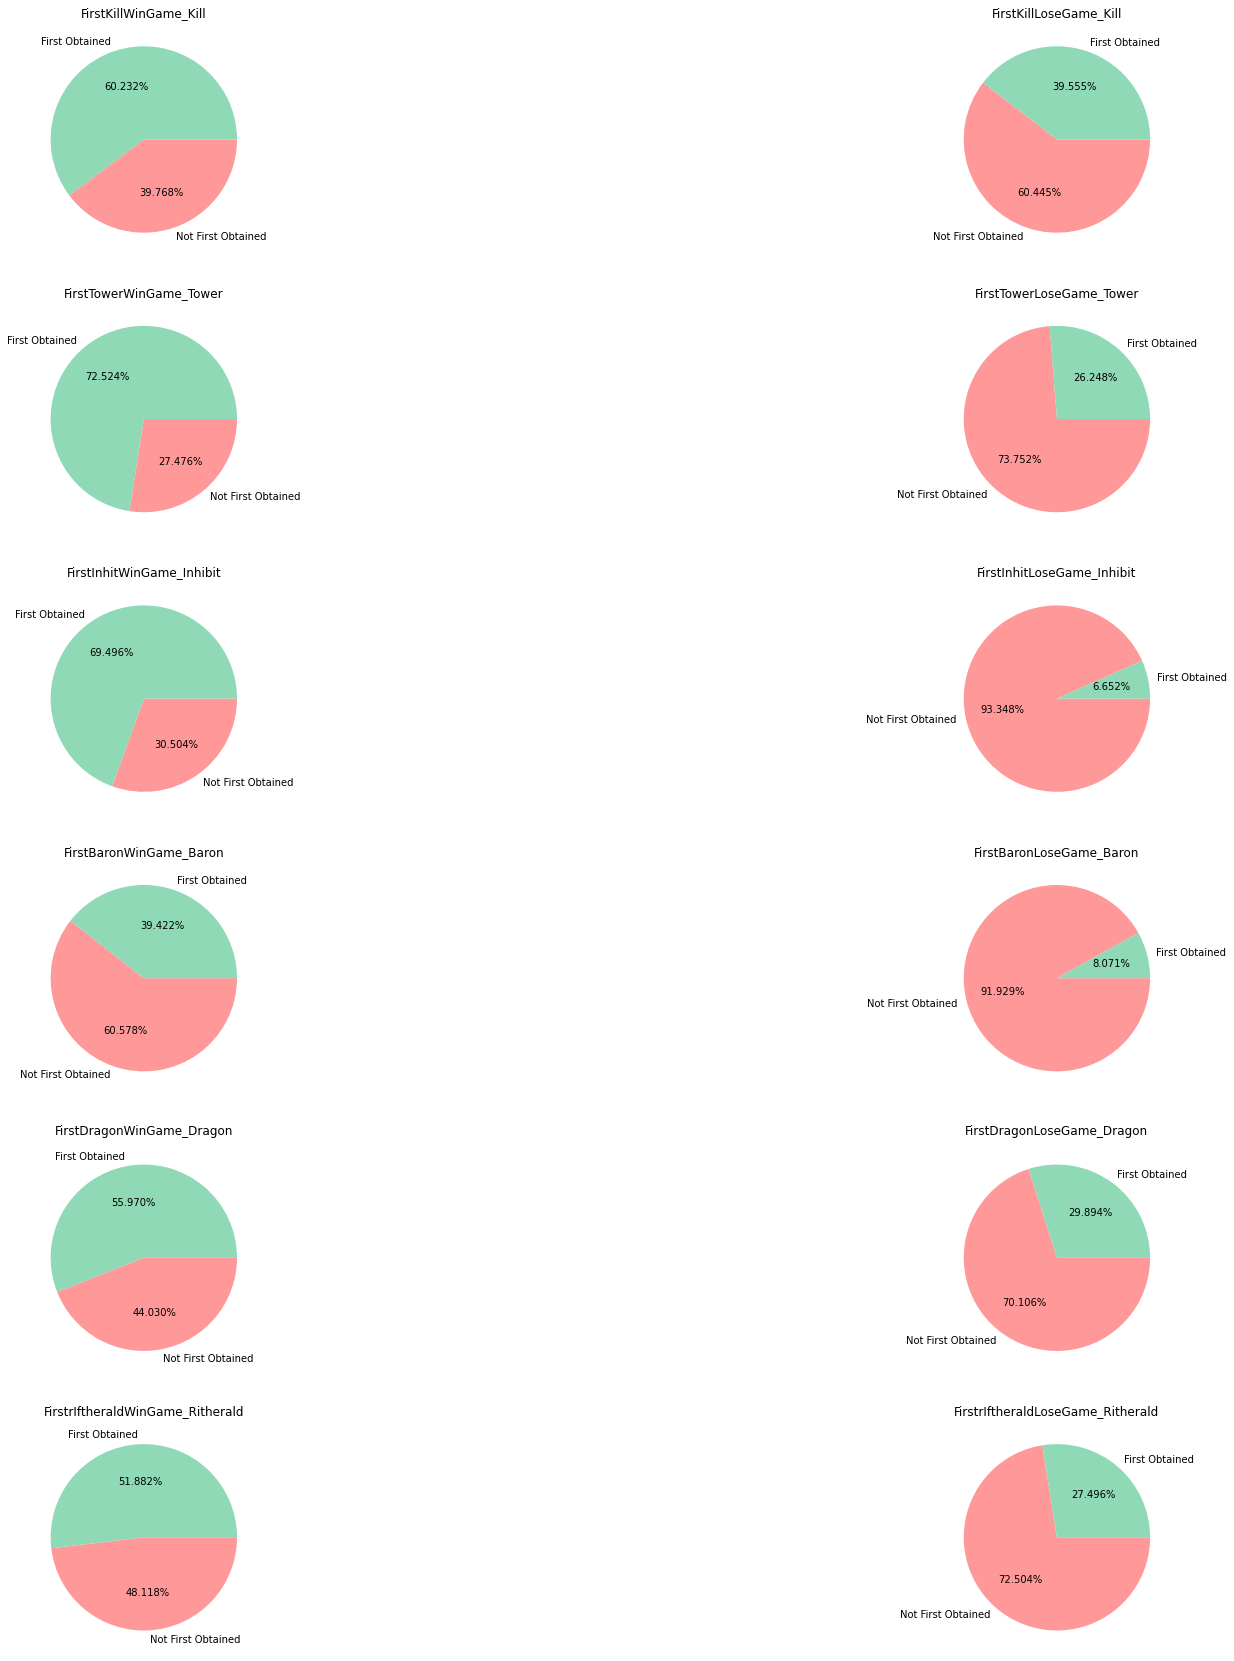

In [ ]:
# 데이터 시각화

# 총 17만개의 게임경기 데이터
colors = ['#FF9999', '#8fd9b6']
fig, axes = plt.subplots(6,2,figsize=(30,30))

num = 0
for i in range(6):
    for j in range(2):
        axes[i][j].pie((a[0][num],a[1][num]),labels=['Not First Obtained','First Obtained'],autopct='%.3f%%', startangle=360, counterclock=False, colors = colors)
        num += 1

axes[0][0].set_title("FirstKillWinGame_Kill")
axes[0][1].set_title("FirstKillLoseGame_Kill")        
axes[1][0].set_title("FirstTowerWinGame_Tower")
axes[1][1].set_title("FirstTowerLoseGame_Tower")    
axes[2][0].set_title("FirstInhitWinGame_Inhibit")
axes[2][1].set_title("FirstInhitLoseGame_Inhibit")    
axes[3][0].set_title("FirstBaronWinGame_Baron")
axes[3][1].set_title("FirstBaronLoseGame_Baron")  
axes[4][0].set_title("FirstDragonWinGame_Dragon")
axes[4][1].set_title("FirstDragonLoseGame_Dragon")    
axes[5][0].set_title("FirstrIftheraldWinGame_Ritherald")
axes[5][1].set_title("FirstrIftheraldLoseGame_Ritherald")    

plt.show()

In [ ]:
lol_data.head(5)

,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,vilemawKills,riftHeraldKills,dominionVictoryScore
0,200,1,False,True,True,False,True,True,9,1,0,3,0,2,0
1,100,1,False,False,False,False,True,True,4,0,0,2,0,2,0
2,200,1,True,True,True,False,True,True,5,1,0,2,0,2,0
3,200,1,True,True,False,False,False,True,6,0,1,3,0,1,0
4,100,1,True,True,True,True,True,True,11,3,2,2,0,2,0


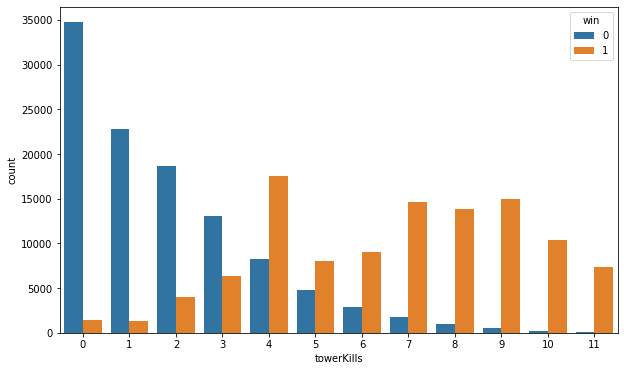

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='towerKills', hue='win', data=lol_data)
plt.show()

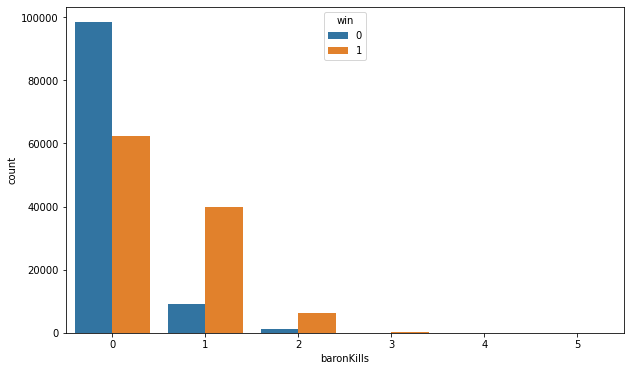

In [ ]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=0)
kda_2 = sns.countplot(x='baronKills', hue='win', data=lol_data)
plt.show()

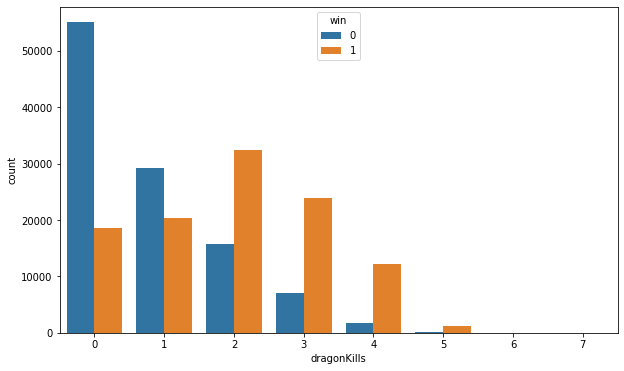

In [ ]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=0)
kda_2 = sns.countplot(x='dragonKills', hue='win', data=lol_data)
plt.show()

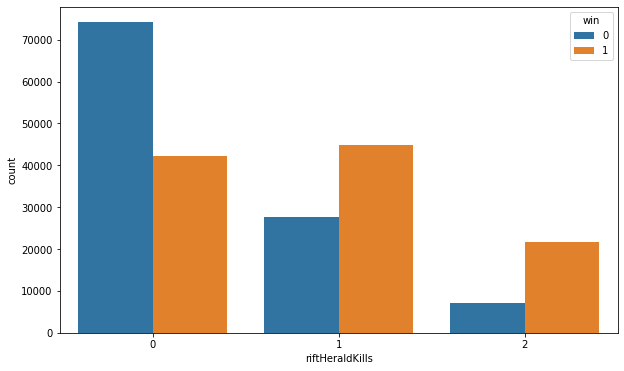

In [ ]:
plt.figure(figsize=(10, 6))
plt.xticks(rotation=0)
kda_2 = sns.countplot(x='riftHeraldKills', hue='win', data=lol_data)
plt.show()

In [ ]:
col_names = ["win", "towerKills",	"inhibitorKills",	"baronKills",	"dragonKills",	"vilemawKills",	"riftHeraldKills"]
lol_data2 = lol_data[col_names]

In [ ]:
lol_data2

,win,towerKills,inhibitorKills,baronKills,dragonKills,vilemawKills,riftHeraldKills
0,1,9,1,0,3,0,2
1,1,4,0,0,2,0,2
2,1,5,1,0,2,0,2
3,1,6,0,1,3,0,1
4,1,11,3,2,2,0,2
...,...,...,...,...,...,...,...
217641,0,3,0,0,1,0,0
217642,0,3,0,0,2,0,2
217643,0,6,1,0,3,0,1
217644,0,5,0,1,3,0,0


<AxesSubplot:>

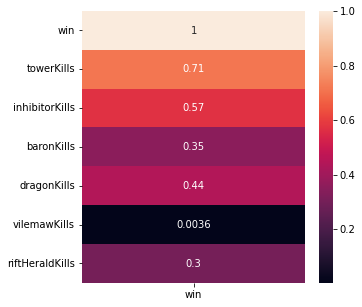

In [ ]:
heatmap_test = plt.figure(figsize=(5,5))
sns.heatmap(lol_data2.corr()[['win']], annot = True)

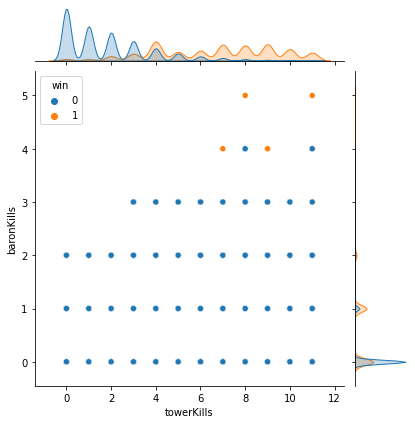

In [ ]:
sns.jointplot(x='towerKills',y='baronKills', hue='win', data=lol_data)
plt.show()

In [ ]:
sns.jointplot(x='towerKills',y='inhibitorKills', hue='win', data=lose_data)
plt.show()

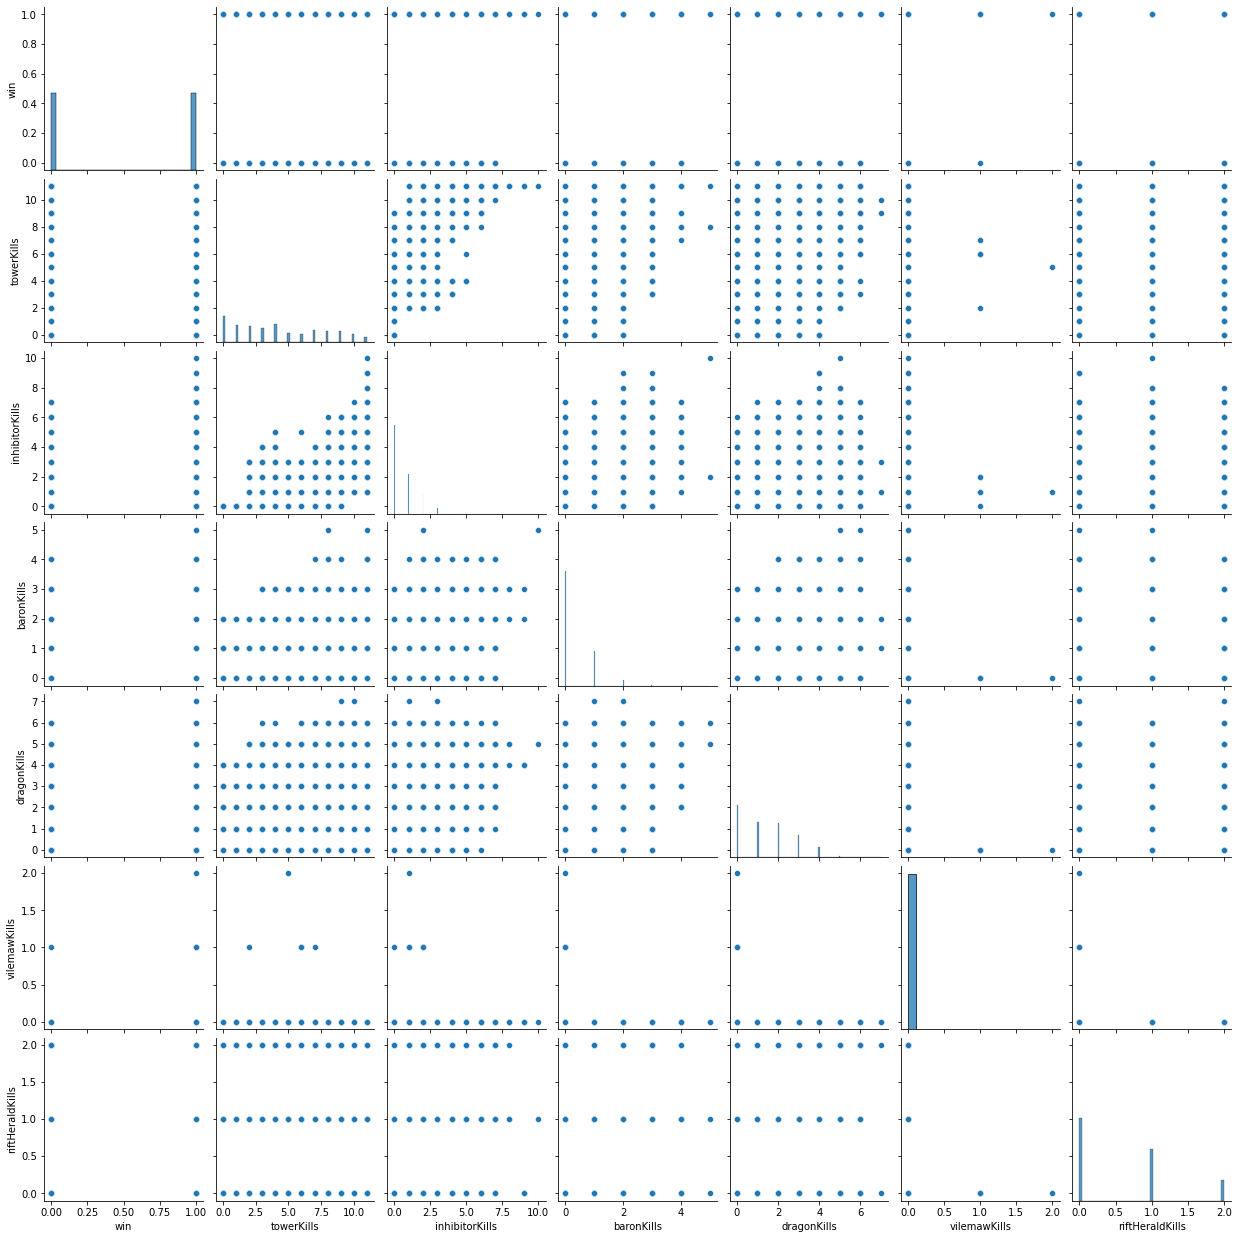

In [ ]:
sns.pairplot(lol_data2)
plt.show()